# Insight Data Science Project: Airbn'Tots

As part of the Insight Data Science program, I decided to create a Chrome extension that will classify Airbnb listings as small kid friendly or not (suitable to travelers with children in the age range of 1-6 years old).
I used data from the website "Inside Airbnb". I look at ~30K unique listings in NYC with over 1M reviews. In order to label the train data set, I create a bag of words that identify reviews that were written by parents of small children. I then perform a sentiment analysis to the parent reviews by using VADER score. I have ~3K unique listings for which there exists parents reviews. Listings that had positive parent reviews, I label as young kid friendly. I then look at the rest of the reviews to these ~3K listings, and perform a sentiment analysis to them.  Using the mean and minimum VADER scores of the non-parents reviews, I train a Random Forest to predict if a listing is young kid-friendly or not. Using cross-validation, the model has a recall of 75% and a precision of 100%.  However, this is to be expected, since my sample is somewhat biased, looking only at listings with parents reviews. Also, most of the reviews on Airbnb are positive, so in this case a deterministic model that says are listings are young kid friendly would have a high precision.


In [2]:
# Import libraries
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import ensemble
from sklearn.model_selection import train_test_split
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
# Define a function that gives a sentiment score to text
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)  #Calling the polarity analyzer
    print("{:-<40} {}".format(sentence, str(snt)))

In [4]:
# Download Airbnb listings database with full reviews for NYC, July 8 2019
Airbnb_listings_reviews = pd.read_csv('C:/Users/Yaarit/Documents/Insight/Insight_Project/Airbnb_reviews.csv',low_memory=False)

In [5]:
# Download Airbnb listings summary database for NYC, July 8 2019
Airbnb_listings_summary = pd.read_csv('C:/Users/Yaarit/Documents/Insight/Insight_Project/Airbnb_listings_summary.csv',low_memory=False)

In [6]:
# Download Airbnb listings database for NYC, July 8 2019
Airbnb_listings = pd.read_csv('C:/Users/Yaarit/Documents/Insight/Insight_Project/Airbnb_listings.csv',low_memory=False)

In [7]:
#Remove any duplicate row
Airbnb_listings_reviews.drop_duplicates(inplace=True)

In [8]:
#Remove any duplicate row
Airbnb_listings_summary.drop_duplicates(inplace=True)

In [9]:
#Remove any duplicate row
Airbnb_listings.drop_duplicates(inplace=True)

In [10]:
Airbnb_listings_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2539,55688172,12/4/2015,25160947,Peter,Great host
1,2539,97474898,8/27/2016,91513326,Liz,Nice room for the price. Great neighborhood. J...
2,2539,105340344,10/1/2016,90022459,Евгений,Very nice apt. New remodeled.
3,2539,133131670,2/20/2017,116165195,George,Great place to stay for a while. John is a gre...
4,2539,138349776,3/19/2017,118432644,Carlos,.


In [11]:
print("There are "+ str(len(Airbnb_listings_reviews)) + " reviews")

There are 1048575 reviews


In [12]:
#Checking for rows with no reviews
Airbnb_listings_reviews['comments'].isnull().sum()

457

In [13]:
#Checking for rows with a missing id_listing
Airbnb_listings_reviews['listing_id'].isnull().sum()

0

In [14]:
# Remove any listing that has a missing value
Airbnb_listings_reviews = Airbnb_listings_reviews.dropna()

In [15]:
# count the number of reviews
len(Airbnb_listings_reviews)

1048117

In [16]:
# Count the number of unique listings
print("There are " + str(len(Airbnb_listings_reviews.groupby(['listing_id']))) + " unique listings")

There are 29247 unique listings


Define a bag of words that with high probablity indicate a review by a parent to young kids.

In [17]:
words_of_kids= ['baby', 'babies','toddler','toddlers', 'infant', 'infants', '1 year old', '2 year old', '3 year old', '4 year old', '5 year old', 'young kids', 'small kids','kiddie','kiddos', 'kiddo', 'preschooler','kindergartner']
# Find all reviews that are most likely parents reviews (according to the bag of words)
Airbnb_listings_reviews_parents = Airbnb_listings_reviews[Airbnb_listings_reviews.comments.str.contains('|'.join(words_of_kids ))]

Examining the reviews, it appears that many people use the phrase "slept like a baby", and so we want to remove those reviews from our subset of parents revies:

In [18]:
# Remove reviews that included the phrase "like a baby", since this was written by people who slept like a baby and not by parents.
Airbnb_listings_reviews_parents = Airbnb_listings_reviews_parents[~Airbnb_listings_reviews_parents['comments'].str.contains("like a baby")]

In [19]:
Airbnb_listings_reviews_parents = Airbnb_listings_reviews_parents[~Airbnb_listings_reviews_parents['comments'].str.contains("like babies")]

In [20]:
# Count how many parents reviews - 5,206
print ("There are " + str(len(Airbnb_listings_reviews_parents)) +" parent reviews")
# Unique list of listings with parents reviews - 3,027
print("There are " + str(len(Airbnb_listings_reviews_parents.groupby(['listing_id']))) + " unique listings with parent reviews")

There are 5206 parent reviews
There are 3027 unique listings with parent reviews


I will create a list of unique listings that do not have parent reviews for possible future use:

In [21]:
Airbnb_listings_nonparents = pd.concat([Airbnb_listings_reviews['listing_id'].drop_duplicates(),Airbnb_listings_reviews_parents['listing_id'].drop_duplicates()])
Airbnb_listings_nonparents.drop_duplicates(keep=False, inplace = True)
len(Airbnb_listings_nonparents)

26220

For now, I will look only at listings with parent reviews. I will use the parent reviews for labeling the data and then train a model without them.

In [22]:
Airbnb_listings_parents = Airbnb_listings_reviews_parents['listing_id'].drop_duplicates()

In [23]:
# Find all reviews by non parents
Airbnb_nonparents_reviews = pd.concat([Airbnb_listings_reviews,Airbnb_listings_reviews_parents]).drop_duplicates(keep=False)

In order to train a model I will find all non-parents reviews to the listings that had parent reviews.

In [24]:
# Find all reviews by non-parents to listings that have parent reviews
df = Airbnb_nonparents_reviews[Airbnb_nonparents_reviews['listing_id'].isin(Airbnb_listings_parents)].groupby('listing_id').count()

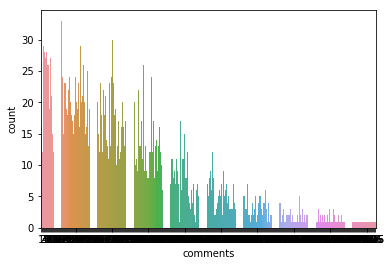

In [25]:
#Distribution of the number of comments per listing
sns.countplot(x = 'comments', data=df)

In [26]:
# Let's check how many listings have only one comment or none
df[(df['comments']<2)].count()

id               16
date             16
reviewer_id      16
reviewer_name    16
comments         16
dtype: int64

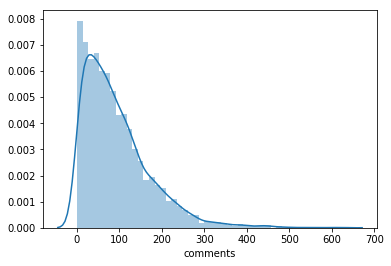

In [27]:
#Plot the distribution function of # of comments
x = df['comments']
sns.distplot(x)

We are now ready to start analyzing our sample data (the listings that have parent reviews):

In [28]:
# Define our sample set

Sample = Airbnb_listings_reviews[Airbnb_listings_reviews['listing_id'].isin(Airbnb_listings_parents)]

In [29]:
# Compute the sentiment score to the reviews in our sample data

analyser = SentimentIntensityAnalyzer()

i=0 #counter

compval = [ ]  #empty list to hold our computed 'compound' VADER scores


while (i<len(Sample)):

    k = analyser.polarity_scores(Sample.iloc[i]['comments'])
    compval.append(k['compound'])
    
    i = i+1
    
#converting sentiment values to numpy for easier usage

compval = np.array(compval)

len(compval)

290333

We can now add the VADER score of each review as another colunm to our data frame:

In [30]:
Sample['VADER score'] = compval

C:\Users\Yaarit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
Sample.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,VADER score
9,2595,17857,11/21/2009,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...,-0.3612
10,2595,19176,12/5/2009,53267,Cate,Great experience.,0.6249
11,2595,19760,12/10/2009,38960,Anita,I've stayed with my friend at the Midtown Cast...,0.9248
12,2595,34320,4/9/2010,71130,Kai-Uwe,"We've been staying here for about 9 nights, en...",0.9229
13,2595,46312,5/25/2010,117113,Alicia,We had a wonderful stay at Jennifer's charming...,0.9464


Find the negative comments:

In [32]:
Sample[(Sample['VADER score']<=0.05)]
# 32,558 non-positive reviews - about 11% of total reviews in the sample

,listing_id,id,date,reviewer_id,reviewer_name,comments,VADER score
9,2595,17857,11/21/2009,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...,-0.3612
22,2595,21464102,10/18/2014,16584002,Kitty,We hebben genoten van ons verblijf in het appa...,0.0000
30,2595,194307810,9/16/2017,81450805,Marina,Tiene una ubicación excelente. Buen equipamien...,0.0000
34,2595,216355494,12/3/2017,2888785,Claudia,This is a nice apartment and it looks like in ...,-0.5440
44,2595,331029784,10/1/2018,174975601,Julie,The location made getting to Time Square easil...,-0.2960
52,2595,449815873,5/7/2019,168460710,Christopher,10 / 10 would stay again,0.0000
59,3831,25015185,1/5/2015,22720105,Olivier,"Lisa était sympa, toujours prête à aider. L'ét...",0.0000
60,3831,31281064,5/3/2015,27038205,Florieke,The reservation was canceled 5 days before arr...,0.0000
64,3831,42307078,8/12/2015,38246619,Alain,"Bien que la chambre soit défraichi, nous avons...",-0.2732
75,3831,50439347,10/12/2015,38334605,Luca,Alla fine tutto è bene ciò che finisce bene......,-0.2500


In [33]:
# Compute the sentiment score to the parent reviews

analyser = SentimentIntensityAnalyzer()

i=0 #counter

compval2 = [ ]  #empty list to hold our computed 'compound' VADER scores


while (i<len(Airbnb_listings_reviews_parents)):

    k = analyser.polarity_scores(Airbnb_listings_reviews_parents.iloc[i]['comments'])
    compval2.append(k['compound'])
    
    i = i+1
    
#converting sentiment values to numpy for easier usage

compval2 = np.array(compval2)

len(compval2)

5206

In [34]:
# Add the sentiment score colunm
Airbnb_listings_reviews_parents['VADER score'] = compval2

We will label the data according to the mean of the parents reviews sentiment scores for each listing.

In [35]:
# Finding mean sentiment of parents reviews
Airbnb_listings_parents_mean_score = Airbnb_listings_reviews_parents.groupby('listing_id')['VADER score'].mean()

In [36]:
# Creating labels 
label = Airbnb_listings_parents_mean_score.to_frame()

Our data labeling will be a binary label, since at this point I only classify listings as kid-friensly or not:

In [37]:
# Define function to give a binary score to parent reviews sentiment
def label_sentiment(row):
    if row['VADER score'] > 0.25 :
        return 1
    else:
        return 0

In [38]:
# Creating labels for kid friendly listings
labeling = label.apply (lambda row: label_sentiment(row), axis=1).to_frame()
len(labeling)

3027

In [39]:
# 4.2% of listings are not kid-friendly
labeling[labeling[0]>0].count()

0    2901
dtype: int64

In [40]:
# Create a table with the id listing and it's label
labeling['id'] = labeling.index
labeling.columns=['label','id']
labeling.head()
#len(labeling) = 3,027

,label,id
listing_id,,
2595,1,2595
3831,1,3831
5203,1,5203
5803,1,5803
7097,1,7097


In [41]:
# There are 164 reviews that has a VADER score below 0.05 (almost 97% of all parents reviews)
Airbnb_listings_reviews_parents[(Airbnb_listings_reviews_parents['VADER score']<0.25)].count()
#Airbnb_listings_reviews_parents[(Airbnb_listings_reviews_parents['VADER score']>0.05)]['VADER score'].mean()
# The mean of the positive reviews is 0.93

listing_id       194
id               194
date             194
reviewer_id      194
reviewer_name    194
comments         194
VADER score      194
dtype: int64

After labeling the data, we will create the features we are interested in to try and predict the listings clafication.
We start with calculating the mean and the minimum of the sentiment scores of the non-parents reviews for each listing.

In [42]:
Airbnb_nonparents_reviews_sentiment = pd.concat([Sample,Airbnb_listings_reviews_parents]).drop_duplicates(keep=False)

In [43]:
Airbnb_listings_mean_score = Airbnb_nonparents_reviews_sentiment.groupby('listing_id')['VADER score'].mean()

In [44]:
Airbnb_listings_mean_score.to_frame()
Airbnb_listings_mean_score.columns = ['mean VADER score']

In [45]:
Airbnb_listings_min_score = Airbnb_nonparents_reviews_sentiment.groupby(['listing_id'])['VADER score'].min()

In [46]:
Airbnb_listings_min_score.to_frame()
Airbnb_listings_min_score.columns = ['min VADER score']

Creating a table with the two features we created per listing_id

In [48]:
df1 = pd.merge(Airbnb_listings_mean_score, Airbnb_listings_min_score, right_index=True, left_index=True)

In [49]:
df1['id'] = df1.index
df1.head()
#len(df1) = 3,016

,VADER score_x,VADER score_y,id
listing_id,,,
2595,0.742975,-0.5440,2595
3831,0.672944,-0.9923,3831
5203,0.938878,0.0000,5203
5803,0.854450,-0.9708,5803
7097,0.865991,-0.9186,7097


We are now able to create our sample data frame with the two new features without the listings labeling

In [50]:
# Our sample data without the labeling
ModelSetX = pd.merge(Airbnb_listings[Airbnb_listings['id'].isin(Airbnb_listings_parents)],df1, on = 'id')
ModelSetX.rename(columns={"VADER score_x": "mean VADER score", "VADER score_y": "min VADER score"})

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,mean VADER score,min VADER score
0,2595,https://www.airbnb.com/rooms/2595,20190708031610,43655,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,strict_14_with_grace_period,t,t,2,1,0,1,0.38,0.742975,-0.5440
1,3831,https://www.airbnb.com/rooms/3831,20190708031610,43655,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,moderate,f,f,1,1,0,0,4.64,0.672944,-0.9923
2,5203,https://www.airbnb.com/rooms/5203,20190708031610,43654,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Stay in my family's little guest room and enj...,"Our best guests are seeking a safe, clean, spa...",none,Our neighborhood is full of restaurants and ca...,...,flexible,t,t,1,0,1,0,0.99,0.938878,0.0000
3,5803,https://www.airbnb.com/rooms/5803,20190708031610,43655,"Lovely Room 1, Garden, Best Area, Legal rental","Beautiful house, gorgeous garden, patio, cozy ...","Welcome to an historic, stunning 4-story Brook...","Beautiful house, gorgeous garden, patio, cozy ...",none,Neighborhood is amazing! Best subways to Manha...,...,strict_14_with_grace_period,t,f,3,1,2,0,1.34,0.854450,-0.9708
4,7097,https://www.airbnb.com/rooms/7097,20190708031610,43655,Perfect for Your Parents + Garden,This is a floor of our four-story brownstone o...,Are your parents coming to town? They'll love ...,This is a floor of our four-story brownstone o...,none,"Residential, village-like atmosphere.",...,flexible,f,f,1,1,0,0,1.72,0.865991,-0.9186
5,7322,https://www.airbnb.com/rooms/7322,20190708031610,43654,Chelsea Perfect,Welcome to New York City and Chelsea Perfect....,"Hey Doti, You are now our #1 host in NYC... B...",Welcome to New York City and Chelsea Perfect....,none,NaN,...,strict_14_with_grace_period,t,t,1,0,1,0,2.12,0.905804,-0.9750
6,7726,https://www.airbnb.com/rooms/7726,20190708031610,43655,Hip Historic Brownstone Apartment with Backyard,Meander down our beautiful tree lined street u...,"You have your own floor with private entrance,...",Meander down our beautiful tree lined street u...,none,"A mix of Caribbean culture, professionals and ...",...,moderate,f,f,1,1,0,0,4.44,0.859173,-0.3680
7,8024,https://www.airbnb.com/rooms/8024,20190708031610,43655,CBG CtyBGd HelpsHaiti rm#1:1-4,"Located in the heart of Park Slope, Bklyn, C...","Welcome to CommunityBeGood,(URL HIDDEN) 30%...","Located in the heart of Park Slope, Bklyn, C...",none,"I love the mixture of ethnicities, foods, fami...",...,moderate,f,t,6,0,6,0,1.09,0.804609,-0.5574
8,9657,https://www.airbnb.com/rooms/9657,20190708031610,43654,Modern 1 BR / NYC / EAST VILLAGE,"Awesome, spacious & clean 1 bedroom with a coz...",The east village offers a mixture of old schoo...,"Awesome, spacious & clean 1 bedroom with a coz...",none,The east village offers a mixture of old schoo...,...,strict_14_with_grace_period,f,f,1,1,0,0,0.24,0.789832,0.0000
9,9668,https://www.airbnb.com/rooms/9668,20190708031610,43654,front room/double bed,for couples or friends who are ok with sharing...,______________________________________________...,for couples or friends who are ok with sharing...,none,Just about everything you will ever need is wi...,...,moderate,f,f,3,0,3,0,2.04,0.699593,-0.9618


Adding the labels, we will now have our prepared sample data

In [51]:
# Adding labels to our sample data
ModelSet = pd.merge(ModelSetX, labeling, on = 'id', how = 'left')
ModelSet=ModelSet.rename(columns={"VADER score_x": "mean VADER score", "VADER score_y": "min VADER score"})

Another feature that can help us with the prediction is the appearence of some keywords in the listing summary.
First I will create another bag of words and then I will check which listings' summaries contain some of them.

In [98]:
summary_kid_friendly_words = ['fully equipped','kid-friendly', 'toys', 'games', 'kitchen', 'family', 'kiddie pool', 'backyard', 'playground']

In [99]:
    def description_contain_words(summary, wordsToCheck):
        for word in wordsToCheck:
            if word in summary:
                return True
        return False

In [111]:
key_summary = []  
for currentSummary in ModelSet['description']:
    #print(currentSummary)
    if pd.isnull(currentSummary) == True:
        key_summary.append(0)
    elif description_contain_words(currentSummary, summary_kid_friendly_words):
        key_summary.append(1)
    else:
        key_summary.append(0)
len(key_summary)           

3016

Add a new colunm with an index of kid-friendly summary:

In [112]:
ModelSet['summaryKidKeyWords'] = key_summary

In [113]:
# We dont really need all the columns
X = ModelSet[['mean VADER score', 'min VADER score', 'summaryKidKeyWords']]

In [114]:
X = X.astype(float)
X.head()

,mean VADER score,min VADER score,summaryKidKeyWords
0,0.742975,-0.5440,1.0
1,0.672944,-0.9923,1.0
2,0.938878,0.0000,1.0
3,0.854450,-0.9708,0.0
4,0.865991,-0.9186,1.0


defining the label colunm as our "y" variable

In [115]:
y = ModelSet[['label']]
y = np.ravel(y)

In [116]:
print("There are " + str(sum(y)) + " listings that are kid-friendly.")
print("There are " + str(len(y)) + " listing.")
print(str(sum(y)/len(y)) +"% of the listings are kid-friendly")

There are 2891 listings that are kid-friendly.
There are 3016 listing.
0.958554376657825% of the listings are kid-friendly


We are now ready to fit a model to our data:
As a first step we split the data into a training and testing sets

In [117]:
# Split the data to trainnnig and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

We will start with a simple model to have as abenchmark - a Logistic Regression:

In [118]:
# Fit regression model
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

C:\Users\Yaarit\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [119]:
score = logisticRegr.score(X_test, y_test)
print("The accuracy of the logistic regression model is " + str(score))

The accuracy of the logistic regression model is 0.9646408839779006


In [120]:
# confusion matrix
from sklearn import metrics

predictions = logisticRegr.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[  0  32]
 [  0 873]]


The logistic regression seems to classify all listings as kid-friendly. It seems it is not dealing well with the imbalanced data.

We will try a Random Forest Classifier:

In [121]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=500)
clf_rf.fit(X_train, y_train)
predict_rf = clf_rf.predict(X_test)

In [122]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict_rf)

array([[  1,  31],
       [  3, 870]], dtype=int64)

The Random Forest is also unable to classift the non kid-friendly listings correctly.

Gradient Bossted Classifier:

In [123]:
clf = ensemble.GradientBoostingClassifier(n_estimators=500)
clf.fit(X_train, y_train)
predict_gbt = clf.predict(X_test)

In [124]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict_gbt)
print(clf.feature_importances_)
clf.score(X_test,y_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict_gbt)

[0.74988947 0.22531447 0.02479606]


array([[  1,  31],
       [ 16, 857]], dtype=int64)

Our sample is very imbalanced, so we will try cross-validation:

Cross-validation:

In [125]:
from sklearn.model_selection import KFold
kfold = KFold(5, False, 1)

GBC:

In [126]:
kf_clf = ensemble.GradientBoostingClassifier(n_estimators=500)
for train, test in kfold.split(X, y):
    kf_clf.fit(X.iloc[train], y[train])

In [127]:
predict_kf_gbt = kf_clf.predict(X_test)
kf_clf.score(X_test, y_test)

0.9867403314917127

In [128]:
print(kf_clf.feature_importances_)
confusion_matrix(y_test, predict_kf_gbt)

[0.71707623 0.25601506 0.02690871]


array([[ 23,   9],
       [  3, 870]], dtype=int64)

Logistic regression:

In [129]:
logisticRegr_os = LogisticRegression()
for train, test in kfold.split(X, y):
    logisticRegr_os.fit(X.iloc[train], y[train])

C:\Users\Yaarit\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yaarit\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yaarit\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yaarit\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Yaarit\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

In [130]:
predictions_os = logisticRegr_os.predict(X_test)
metrics.confusion_matrix(y_test, predictions_os)

array([[  0,  32],
       [  0, 873]], dtype=int64)

Random Forest:

In [131]:
kf_clf_rf = ensemble.RandomForestClassifier(n_estimators=100)
for train, test in kfold.split(X, y):
    kf_clf_rf.fit(X.iloc[train], y[train])

In [132]:
predict_kf_rf = kf_clf_rf.predict(X_test)

In [133]:
confusion_matrix(y_test, predict_kf_rf)

array([[ 24,   8],
       [  0, 873]], dtype=int64)

In [134]:
print(kf_clf_rf.feature_importances_)

[0.60693062 0.38696986 0.00609951]


The key-words I looked at from the summary seem to have very low weight, so we will take them out.

In [140]:
X = ModelSet[['mean VADER score', 'min VADER score']]

In [141]:
X = X.astype(float)

In [142]:
y = ModelSet[['label']]
y = np.ravel(y)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
kf_clf_rf = ensemble.RandomForestClassifier(n_estimators=100)
for train, test in kfold.split(X, y):
    kf_clf_rf.fit(X.iloc[train], y[train])
predict_kf_rf = kf_clf_rf.predict(X_test)
confusion_matrix(y_test, predict_kf_rf)
#print(kf_clf_rf.feature_importances_)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

The random forest with cross-validation seems to perform best!

Pickle the model:

In [144]:
import pickle

pkl_filename = 'AirbnTots_model.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(kf_clf_rf, file)